[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[[  0.           0.        ]
 [  4.69031997   5.87852948]
 [-12.19396993  -8.13862192]
 [  0.79900252  -1.9765162 ]
 [ -0.10500723  -5.33152455]
 [  5.49623734   4.8611996 ]
 [  0.41269186   7.04525754]
 [  2.92193339  -5.37057789]
 [  2.3046924   -5.99301626]
 [  5.49031438  -0.31203694]
 [ -1.15538977  -4.25580965]
 [  7.64088337  -0.96580926]
 [ -2.67704889  -2.20083469]
 [  3.32693241   2.2840254 ]
 [  2.57957882   2.69263127]
 [ 13.38529751  -2.54009385]
 [ -3.20151706  -5.08607955]
 [  3.84987139   7.05607683]
 [ -0.71217161  -5.25097798]
 [ -5.1530076    4.06620492]
 [  4.64533857   3.39471418]
 [ -4.15943567   1.45100827]
 [  0.72928631   1.36680373]
 [  5.44642986   1.39747218]
 [  4.24320977   0.42236918]
 [  1.80699624   3.94555141]
 [ -9.10722387  -1.9979451 ]
 [ -2.93982909  -3.9929865

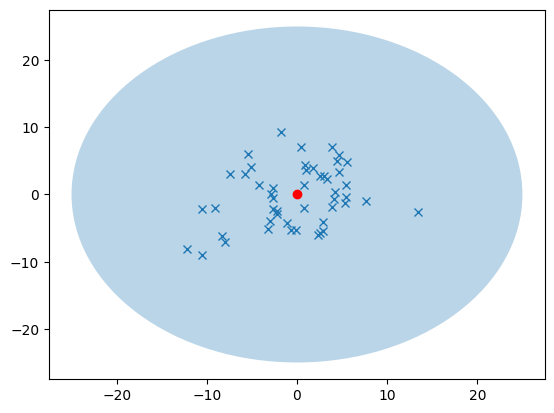

In [102]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib import patches

seed = 42
rng = np.random.default_rng(seed)
N = 50
MAX_RANGE = 50
nodes = list(range(N))
print(nodes)
node_locs = rng.normal(scale=MAX_RANGE / 2 / 4, size=(N, 2))
node_locs[0, :] = 0  # The first node is the depot node (at 0,0)

print(node_locs)
edges = list(edge for edge in itertools.product(nodes, nodes) if edge[0] != edge[1])
print(edges)
distances = [
    np.linalg.norm(node_locs[pt1, :] - node_locs[pt2, :]) for pt1, pt2 in edges
]
distances_dict = {edge: distance for edge, distance in zip(edges, distances)}
print(distances)

plt.gca().add_patch(patches.Circle((0,0), radius=MAX_RANGE / 2, zorder=-10, alpha=0.3))
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "x")



Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20002 rows, 10000 columns and 78905 nonzeros
Model fingerprint: 0x4283ea9b
Variable types: 100 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [3e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Presolve removed 293 rows and 93 columns
Presolve time: 0.42s
Presolved: 19709 rows, 9907 columns, 77852 nonzeros
Variable types: 99 continuous, 9808 integer (9807 binary)
Found heuristic solution: objective 1381.2872934

Root relaxation: objective 1.785514e+02, 413 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumb

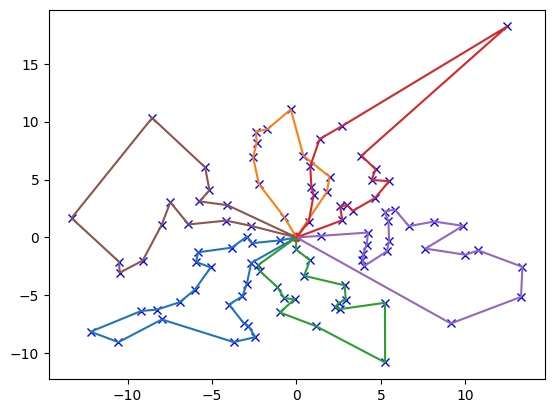

In [49]:
import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx

model = gp.Model()
x = model.addVars(edges, obj=distances_dict, vtype=gp.GRB.BINARY, name="x")
r = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, name="range")

# Conserve flow at depot node
model.addConstr(x.sum(nodes[0], "*") == x.sum("*", nodes[0]))
# Ensure at least one tour goes through the depot
model.addConstr(x.sum(nodes[0], "*") >= 1)
# Set the residual range at the depot to the max
model.addConstr(r[nodes[0]] == MAX_RANGE)

# Only one exit from each non-depot node
model.addConstrs(x.sum(node, "*") == 1 for node in nodes[1:])
# Only one entrance to each non-depot node
model.addConstrs(x.sum("*", node) == 1 for node in nodes[1:])

# Ensure residual range is always enough to complete route
model.addConstrs(r[node] >= distances_dict[node, nodes[0]] for node in nodes[1:])
# Ensure residual range doesn't go above max (may be redundant)
model.addConstrs(r[node] <= MAX_RANGE for node in nodes)
# Constrain the residual range to be propagated through a subtour
# Create equality constraint that only holds when x[i,j] is True (1)
# Don't apply to returning to the depot (j == nodes[0])
model.addConstrs(
    r[j] >= r[i] - distances_dict[i, j] - MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.addConstrs(
    r[j] <= r[i] - distances_dict[i, j] + MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)


def heuristic_solution_cb(model, where, x, nodes, distances):
    if where == gp.GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(x)
        selected = gp.tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)
        # print(selected)
        # subtours = extract_subtours(selected)
        graph = nx.DiGraph(selected)
        did_improve, improved_solution = improve_solution(graph, x, nodes, distances)
        if did_improve:
            model.cbSetSolution(x, improved_solution)


def extract_subtours(selected):
    graph = nx.DiGraph(selected)
    subtours = []
    visited = set()
    visited.add(nodes[0])
    for next_node in graph.successors(nodes[0]):
        subtour = [nodes[0]]
        while next_node != nodes[0]:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)

    for node in nodes[1:]:
        if node in visited:
            continue
        subtour = [node]
        next_nodes = list(graph.successors(node))
        assert len(next_nodes) == 1
        next_node = next_nodes[0]
        while next_node != node:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)
    return subtours


def improve_solution(subtour_graph, x, nodes, distances):
    improved_solution = False
    for node in subtour_graph.nodes:
        if node == nodes[0]:
            continue
        prev_ = next(subtour_graph.predecessors(node))
        next_ = next(subtour_graph.successors(node))
        improvements = []
        for other_node in subtour_graph.nodes:
            if node == other_node:
                continue
            other_next = next(subtour_graph.successors(other_node))
            curr_cost = (
                distances[prev_, node]
                + distances[node, next_]
                + distances[other_node, other_next]
            )
            try:
                swapped_cost = (
                    distances[other_node, node]
                    + distances[node, other_next]
                    + distances[prev_, next_]
                )
            except KeyError:
                continue
            cost_improvement = curr_cost - swapped_cost
            improvements.append((cost_improvement, (other_node, other_next)))
        if not improvements:
            continue
        max_improvement = max(improvements, key=lambda x: x[0])
        if max_improvement[0] > 0:
            improved_solution = True
            subtour_graph.remove_edges_from(
                ((prev_, node), (node, next_), max_improvement[1])
            )
            new_prev, new_next = max_improvement[1]
            subtour_graph.add_edges_from(
                ((prev_, next_), (new_prev, node), (node, new_next))
            )
    solution = {}
    for i, j in x:
        if subtour_graph.has_edge(i, j):
            solution[i, j] = 1
        else:
            solution[i, j] = 0
    if improved_solution:
        print("Improved the solution!")
    return improved_solution, solution


# model.Params.LazyConstraints = 1
# model.Params.OutputFlag = 0
model.Params.TimeLimit = 300
model.optimize(
    lambda model, where: heuristic_solution_cb(
        model, where, x=x, nodes=nodes, distances=distances_dict
    )
)

vals = model.getAttr("x", x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
print(selected)
tours = extract_subtours(selected)
print(tours)
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for tour in tours:
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[node]
    pts[-1] = node_locs[0]
    plt.plot(pts[:, 0], pts[:, 1])


Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20002 rows, 10000 columns and 78905 nonzeros
Model fingerprint: 0x4283ea9b
Variable types: 100 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [3e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Presolve removed 293 rows and 93 columns
Presolve time: 0.40s
Presolved: 19709 rows, 9907 columns, 77852 nonzeros
Variable types: 99 continuous, 9808 integer (9807 binary)
Improved the solution!
Found heuristic solution: objective 1381.2872934

Root relaxation: objective 1.785514e+02, 413 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

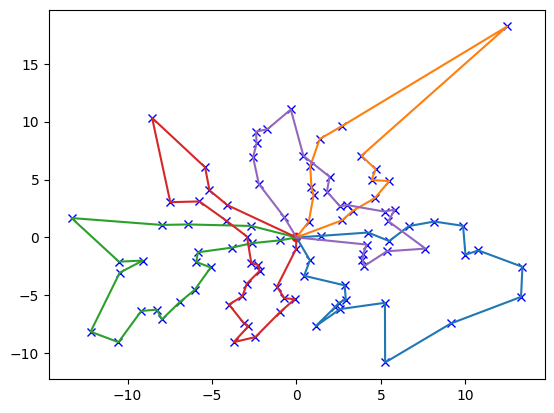

In [50]:
import verypy.util
import verypy.local_search
from verypy.local_search import inter_route_operators, intra_route_operators

import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

model = gp.Model()
x = model.addVars(edges, obj=distances_dict, vtype=gp.GRB.BINARY, name="x")
r = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, name="range")

# Conserve flow at depot node
model.addConstr(x.sum(nodes[0], "*") == x.sum("*", nodes[0]))
# Ensure at least one tour goes through the depot
model.addConstr(x.sum(nodes[0], "*") >= 1)
# Set the residual range at the depot to the max
model.addConstr(r[nodes[0]] == MAX_RANGE)

# Only one exit from each non-depot node
model.addConstrs(x.sum(node, "*") == 1 for node in nodes[1:])
# Only one entrance to each non-depot node
model.addConstrs(x.sum("*", node) == 1 for node in nodes[1:])

# Ensure residual range is always enough to complete route
model.addConstrs(r[node] >= distances_dict[node, nodes[0]] for node in nodes[1:])
# Ensure residual range doesn't go above max (may be redundant)
model.addConstrs(r[node] <= MAX_RANGE for node in nodes)
# Constrain the residual range to be propagated through a subtour
# Create equality constraint that only holds when x[i,j] is True (1)
# Don't apply to returning to the depot (j == nodes[0])
model.addConstrs(
    r[j] >= r[i] - distances_dict[i, j] - MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.addConstrs(
    r[j] <= r[i] - distances_dict[i, j] + MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)


def heuristic_solution_cb(model, where, x, nodes, distances):
    if where == gp.GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(x)
        selected = gp.tuplelist((i, j) for i, j in x.keys() if vals[i, j] > 0.5)
        # print(selected)
        subtours = extract_subtours(selected)
        # graph = nx.DiGraph(selected)
        did_improve, improved_solution = improve_solution(subtours, x, nodes, distances)
        if did_improve:
            model.cbSetSolution(x, improved_solution)


def extract_subtours(selected):
    graph = nx.DiGraph(selected)
    subtours = []
    visited = set()
    visited.add(nodes[0])
    for next_node in graph.successors(nodes[0]):
        subtour = [nodes[0]]
        while next_node != nodes[0]:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)

    for node in nodes[1:]:
        if node in visited:
            continue
        subtour = [node]
        next_nodes = list(graph.successors(node))
        assert len(next_nodes) == 1
        next_node = next_nodes[0]
        while next_node != node:
            subtour.append(next_node)
            visited.add(next_node)
            next_nodes = list(graph.successors(next_node))
            assert len(next_nodes) == 1
            next_node = next_nodes[0]
        subtours.append(subtour)
    return subtours


def improve_solution(subtours, x, nodes, distances):
    solution = verypy.util.routes2sol(subtours)
    dists = np.zeros((len(nodes), len(nodes)))
    for (i, j), dist in distances.items():
        dists[i, j] = dist
    ls_ops = [inter_route_operators.do_1point_move, inter_route_operators.do_2optstar_move, intra_route_operators.do_2opt_move, intra_route_operators.do_relocate_move]
    new_solution = verypy.local_search.do_local_search(ls_ops, solution, dists, None, None, L=MAX_RANGE, max_iterations=10)
    if new_solution == solution:
        return False, None
    edge_solution = {}
    for node, next_node in zip(new_solution, new_solution[1:]):
        edge_solution[node, next_node] = 1
    for i, j in x:
        if (i, j) not in edge_solution:
            edge_solution[i, j] = 0

    print("Improved the solution!")
    return True, edge_solution


# model.Params.LazyConstraints = 1
# model.Params.OutputFlag = 0
model.Params.TimeLimit = 300
model.optimize(
    lambda model, where: heuristic_solution_cb(
        model, where, x=x, nodes=nodes, distances=distances_dict
    )
)

vals = model.getAttr("x", x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
print(selected)
tours = extract_subtours(selected)
print(tours)
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for tour in tours:
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[node]
    pts[-1] = node_locs[0]
    plt.plot(pts[:, 0], pts[:, 1])


In [4]:
import vrpy

import networkx as nx

graph = nx.DiGraph(
    (i if i != 0 else "Source", j if j != 0 else "Sink", {"cost": distance, "time": distance}) for (i, j), distance in distances_dict.items()
)
problem = vrpy.VehicleRoutingProblem(graph, duration=MAX_RANGE)
problem.solve(time_limit=30, cspy=False, solver="gurobi")
print(problem.best_routes)
print(sum(problem.best_routes_cost.values()))
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
for _, tour in problem.best_routes.items():
    pts = np.zeros((len(tour) + 1, 2))
    for idx, node in enumerate(tour):
        pts[idx] = node_locs[0 if node in {"Source", "Sink"} else node]
    pts[-1] = node_locs[0]
    plt.plot(pts[:, 0], pts[:, 1])

INFO:vrpy.vrp:Clarke & Wright solution found with value 278.4491916416242 and 9 vehicles
INFO:vrpy.vrp:Greedy solution found with value 295.1563099779171 and 7 vehicles


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2023-11-28


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2023-11-28
INFO:vrpy.vrp:iteration 0, 262.83



Interrupt request received

Interrupt request received


Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4952 rows, 2500 columns and 19405 nonzeros
Model fingerprint: 0x795879ff
Variable types: 50 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e-04, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 0.0000000
Presolve removed 100 rows and 1 columns
Presolve time: 0.02s
Presolved: 4852 rows, 2499 columns, 19300 nonzeros
Variable types: 50 continuous, 2449 integer (2449 binary)

Root relaxation: objective -7.564905e+03, 4832 iterations, 1.09 seconds (2.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

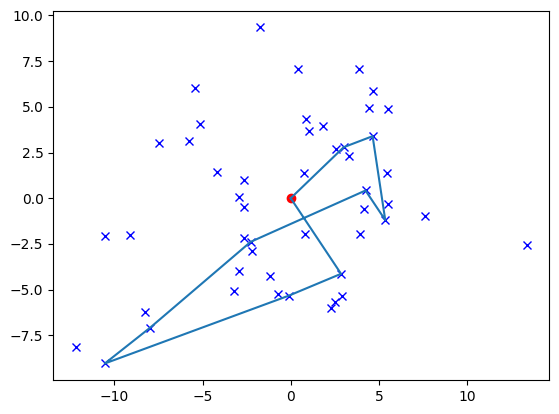

In [103]:
import gurobipy as gp

model = gp.Model()
max_depot_dist = max(distances_dict[0, i] for i in nodes[1:])
costs = {(i, j): distance - 2 * (distances_dict[0, i] if i != 0 else 0) for (i, j), distance in distances_dict.items()}
x = model.addVars(edges, obj=costs, vtype=gp.GRB.BINARY, name="x")
r = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, name="d")
model.addConstr(x.sum(nodes[0], "*") == 1)
model.addConstr(x.sum("*", nodes[0]) == 1)
model.addConstrs(x.sum(i, "*") == x.sum("*", i) for i in nodes[1:])
# Ensure residual range is always enough to complete route
model.addConstrs(r[node] >= distances_dict[node, nodes[0]] for node in nodes[1:])
# Ensure residual range doesn't go above max (may be redundant)
model.addConstrs(r[node] <= MAX_RANGE for node in nodes)
# Constrain the residual range to be propagated through a subtour
# Create equality constraint that only holds when x[i,j] is True (1)
# Don't apply to returning to the depot (j == nodes[0])
model.addConstrs(
    r[j] >= r[i] - distances_dict[i, j] - MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.addConstrs(
    r[j] <= r[i] - distances_dict[i, j] + MAX_RANGE * (1 - x[i, j])
    for i, j in itertools.product(nodes, nodes[1:])
    if i != j
)
model.Params.TimeLimit = 300
model.optimize(
    # lambda model, where: heuristic_solution_cb(
    #     model, where, x=x, nodes=nodes, distances=distances_dict
    # )
)

vals = model.getAttr("x", x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
print(selected)
graph = nx.DiGraph(selected)
cycle = nx.find_cycle(graph)
tour = [i for i, _ in cycle] + [nodes[0]]
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
pts = np.zeros((len(tour) + 1, 2))
for idx, node in enumerate(tour):
    pts[idx] = node_locs[node]
pts[-1] = node_locs[0]
plt.plot(pts[:, 0], pts[:, 1])

['Source', 49, 5, 1, 32, 20, 13, 44, 14, 22, 'Sink']


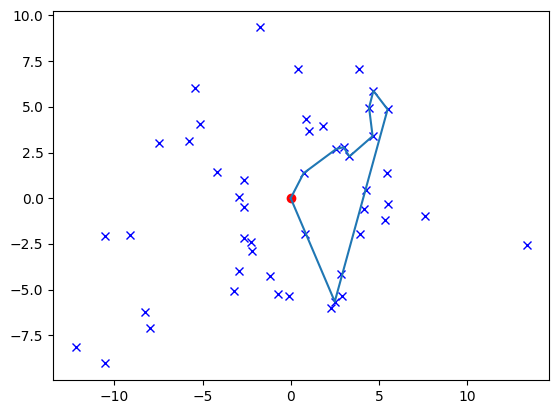

In [104]:
import networkx as nx
import cspy

graph = nx.DiGraph()
graph.graph["n_res"] = 1
total_depot_dist = sum(distances_dict[0, i] for i in nodes[1:])
graph.add_edges_from(
    (
        i if i != nodes[0] else "Source", 
        j if j != nodes[0] else "Sink", 
        {
            "weight": (
                d 
                - 2 * (distances_dict[0, i] if i != 0 else 0)
            ),
            "res_cost": [distances_dict[i, j]],
        }
    ) 
    for (i, j), d in distances_dict.items()
)
alg = cspy.BiDirectional(graph, [MAX_RANGE], [0], time_limit=300, elementary=True)
alg.run()
tour = alg.path
print(tour)
tour = [i if i not in ["Source", "Sink"] else nodes[0] for i in tour]
plt.plot(node_locs[0, 0], node_locs[0, 1], "or")
plt.plot(node_locs[1:, 0], node_locs[1:, 1], "xb")
pts = np.zeros((len(tour) + 1, 2))
for idx, node in enumerate(tour):
    pts[idx] = node_locs[node]
pts[-1] = node_locs[0]
plt.plot(pts[:, 0], pts[:, 1])